In [1]:
from pathlib import Path
import h5py
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import subprocess

In [3]:
# Предполагая, что MAZUR уже определен как путь к папке
file_path = MAZUR / "lncRNA_Peaks_Correlations_corrected_non_zero_0.hdf5"

# Открываем файл в режиме чтения
with h5py.File(file_path, 'r') as f:
    # Просмотрим ключи верхнего уровня
    print("Keys: %s" % f.keys())

Keys: <KeysViewHDF5 ['corrs_matrix', 'lncRNAs_names']>


In [24]:
lncRNA = b"ENSG00000099869"
lncRNAs.index(lncRNA)

0

In [6]:
len(corrs)

95

In [ ]:
with h5py.File(MAZUR / "lncRNA_Peaks_Correlations_corrected_non_zero_0.hdf5", 'r') as f:
    res = f

In [ ]:
corrs

In [13]:
type(test)

h5py._hl.files.File

In [16]:
test

<Closed HDF5 file>

In [8]:
def get_correlated_peaks(lncRNA, hm, output_bed=None):
    with h5py.File(Path("/data/mazurovev/all_marks") / hm / "lncRNA_Peaks_corrs/lncRNA_Peaks_Correlations_corrected_non_zero_0.hdf5", 'r') as f:
        lncRNAs = list(f['lncRNAs_names'][:])
        ind = lncRNAs.index(lncRNA)
        corrs = f['corrs_matrix'][ind, :]
    
    nonzero_corrs = corrs[np.nonzero(corrs)[0]]
    nonzero_peaks = ["peak_" + str(i) for i in np.nonzero(corrs)[0]]
    
    peaks = pd.read_csv(Path("/data/mazurovev/all_marks") / hm / "merged_peaks_first_in_biosample.bed", sep="\t", header=None)
    res = peaks[peaks[3].isin(nonzero_peaks)]
    if output_bed:
        res.to_csv(output_bed, sep="\t", index=None)
    else:
        return res

In [9]:
df = get_correlated_peaks("b'ENSG00000099869", "methylation")

ValueError: "b'ENSG00000099869" is not in list

In [2]:
MAZUR = Path("/data/mazurovev/all_marks/methylation/lncRNA_Peaks_corrs").resolve()

In [3]:
with h5py.File(MAZUR / "lncRNA_Peaks_Correlations_corrected_non_zero_0.hdf5", 'r') as f:
    lncRNAs = list(f['lncRNAs_names'][:])
    corrs = f['corrs_matrix'][:]

In [4]:
len(lncRNAs)

95

In [15]:
lncRNAs.index(b"ENSG00000099869")

0

In [25]:
def get_correlated_peaks(lncRNA, hm, output_bed=None):
    # Убедиться, что lncRNA в байтовом формате
    if isinstance(lncRNA, str):
        lncRNA = lncRNA.encode()
    
    with h5py.File(Path("/data/mazurovev/all_marks") / hm / "lncRNA_Peaks_corrs/lncRNA_Peaks_Correlations_corrected_non_zero_0.hdf5", 'r') as f:
        lncRNAs = list(f['lncRNAs_names'][:])
        try:
            ind = lncRNAs.index(lncRNA)
        except ValueError:
            raise ValueError(f"{lncRNA} is not in the list of lncRNA names.")
        
        corrs = f['corrs_matrix'][ind, :]
    
    nonzero_corrs = corrs[np.nonzero(corrs)[0]]
    nonzero_peaks = ["peak_" + str(i) for i in np.nonzero(corrs)[0]]
    
    peaks = pd.read_csv(Path("/data/mazurovev/all_marks") / hm / "merged_peaks_first_in_biosample.bed", sep="\t", header=None)
    res = peaks[peaks[3].isin(nonzero_peaks)]
    res["corr"] = nonzero_corrs
    if output_bed:
        res.to_csv(output_bed, sep="\t", index=None)
    else:
        return res

# Исправленный вызов функции
df = get_correlated_peaks(b"ENSG00000099869", "methylation")

/tmp/ipykernel_11153/3004858754.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["corr"] = nonzero_corrs


In [26]:
df.shape

(2, 5)

In [27]:
df

,0,1,2,3,corr
10386212,chr12,49123587,49123588,peak_10386212,-0.887848
49210615,chr8,142304068,142304069,peak_49210615,0.911249


In [3]:
import h5py
import numpy as np
import pandas as pd
from pathlib import Path
PWD = Path().cwd()
MAZUR = Path("/data/mazurovev/all_marks/methylation/lncRNA_Peaks_corrs").resolve()
DATA = Path("../data")
METHYL = DATA / "methylation_peaks"
ANNO = Path("/home/magletdinov/shared/annotations")

In [3]:
import gzip
import pandas as pd

# Функция для чтения GTF-файла и подсчета уникальных генов
def count_genes_in_gtf(gtf_file):
    # Открываем файл
    with gzip.open(gtf_file, 'rt') as f:
        # Считываем строки, относящиеся к генам
        gene_lines = [line for line in f if 'gene' in line and line.split('\t')[2] == 'gene']
        
    # Выделяем ID генов из строк
    gene_ids = set()
    for line in gene_lines:
        # Разбиваем строку на колонки
        columns = line.split('\t')
        # Последняя колонка содержит атрибуты, ищем gene_id
        attributes = columns[8]
        for attribute in attributes.split(';'):
            if 'gene_id' in attribute:
                gene_id = attribute.split('"')[1]
                gene_ids.add(gene_id)
                break
    
    return len(gene_ids)

In [4]:
def get_all_correlated_peaks(hm, to_hdf5, to_save):
    if to_save.exists():
        print(f"Skipped: {to_hdf5.stem}")
        return None
    all_results = []

    # Открываем HDF5 файл
    with h5py.File(to_hdf5, 'r') as f:
        lncRNAs = list(f['lncRNAs_names'][:])
        corrs_matrix = f['corrs_matrix'][:]

    # Читаем пики
    peaks = pd.read_csv(Path("/data/mazurovev/all_marks") / hm / "merged_peaks_first_in_biosample.bed", sep="\t", header=None)

    for i, lncRNA in enumerate(lncRNAs):
        corrs = corrs_matrix[i, :]
        nonzero_indices = np.nonzero(corrs)[0]
        nonzero_corrs = corrs[nonzero_indices]
        nonzero_peaks = ["peak_" + str(j) for j in nonzero_indices]

        # Извлекаем соответствующие пики
        res = peaks[peaks[3].isin(nonzero_peaks)].copy()
        res["corr"] = nonzero_corrs
        res["lnc_ens"] = lncRNA.decode('utf-8')  # Декодируем байтовую строку в строку

        all_results.append(res)

    # Объединяем все результаты в один DataFrame
    final_result = pd.concat(all_results, ignore_index=True)
    
    final_result.to_csv(to_save, sep="\t", compression="gzip", index=False)

In [5]:
# Указываем путь к файлу
gtf_file = ANNO / "gencode.v31.annotation.gtf.gz"
gene_count = count_genes_in_gtf(gtf_file)
print(f'Number of unique genes: {gene_count}')

Number of unique genes: 60603


In [93]:
# Указываем путь к файлу
gtf_file = ANNO / "gencode.v31.chr_patch_hapl_scaff.annotation.gtf.gz"
gene_count = count_genes_in_gtf(gtf_file)
print(f'Number of unique genes: {gene_count}')

Number of unique genes: 66738


In [119]:
# Указываем путь к файлу
gtf_file = ANNO / "Homo_sapiens.GRCh37.87.chr_patch_hapl_scaff.gtf.gz"
anno = pd.read_csv(gtf_file, skiprows=[0,1, 2, 3, 4], sep="\t")
anno.shape

/tmp/ipykernel_2941/2525614845.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  anno = pd.read_csv(gtf_file, skiprows=[0,1, 2, 3, 4], sep="\t")


(2856445, 9)

In [118]:
anno.iloc[:,8].apply(lambda x: x.split(" ")[1]).nunique()

63677

In [120]:
# Указываем путь к файлу
gtf_file = ANNO / "FANTOM_CAT.lv2_permissive.gtf.gz"
anno = pd.read_csv(gtf_file, skiprows=[0,1, 2, 3, 4], sep="\t")
anno.shape

(5181575, 9)

In [122]:
anno.iloc[:,8].apply(lambda x: x.split(" ")[1]).nunique()

124244

In [30]:
df.to_csv(to_save, sep="\t", compression="gzip", index=False)

In [ ]:
for to_hdf5 in MAZUR.glob("*.hdf5"):
    print(to_hdf5.stem)
    to_save = METHYL / f"{to_hdf5.stem}.tsv.gz"
    get_all_correlated_peaks(hm="methylation", to_hdf5=to_hdf5, to_save=to_save)

lncRNA_Peaks_Correlations_corrected_non_zero_4
lncRNA_Peaks_Correlations_corrected_non_zero_5


with Parallel(n_jobs=-1) as pool:
    chunks = pool(
        delayed(indexing_himorna)(hm, lnc_ens, corr_sign, subdf)
        for to_hdf5 in MAZUR.glob("*.hdf5"))
    )

In [ ]:
corr_df = pd.concat([pd.read_csv(to_df, sep="\t") for to_df in METHYL.glob("*.tsv.gz")])
corr_df.sort_values(by=["lnc_ens", "0", "1"], inplace=True)
corr_df.shape

In [ ]:
to_save = METHYL / f"methylation_peaks_with_nonzero_corr.tsv.gz"
corr_df.to_csv(to_save, sep="\t", compression="gzip", index=False)

In [2]:
8

8

In [4]:
PREPROCESSING = Path("../preprocessing")
METHYL_INDEX = PREPROCESSING / "methyl_index"
def indexing_methyl(chunk, lnc_ens, corr_sign, subdf):
    to_index = METHYL_INDEX / chunk
    to_index.mkdir(exist_ok=True, parents=True)
    to_save = to_index / f"methyl-{lnc_ens}-{corr_sign}-.tsv.gz"
    if to_save.exists():
        print(f"Skipped: methyl {lnc_ens} {corr_sign}")
        return None
    subdf.to_csv(to_save, sep="\t", compression="gzip", index=False)

In [ ]:
for to_df in METHYL.glob("*.tsv.gz"):
    print(to_df.stem)
    chunk = to_df.stem.split("_")[6]
    df = pd.read_csv(to_df, sep="\t")
    df.rename(columns={"0":"chrom", "1":"start", "2":"end", "3":"name"}, inplace=True)
    df["corr"] = df["corr"].apply(lambda x: np.round(x, 3))
    df["corr_sign"] = np.where(df["corr"] > 0, "plus", "minus")
    for (lnc_ens, corr_sign), subdf in df.groupby(by=["lnc_ens", "corr_sign"]):
        indexing_methyl(chunk=chunk, lnc_ens=lnc_ens, corr_sign=corr_sign, subdf=subdf)

In [16]:
df["corr_sign"] = np.where(df["corr"] > 0, "plus", "minus")

In [17]:
for (lnc_ens, corr_sign), subdf in df.groupby(by=["lnc_ens", "corr_sign"]):
    print(lnc_ens)
    break

ENSG00000099869


In [23]:
[i for i in METHYL_INDEX.glob("*/*ENSG00000099869*")]

[PosixPath('../preprocessing/methyl_index/0.tsv/methyl-ENSG00000099869-minus-.tsv.gz'),
 PosixPath('../preprocessing/methyl_index/0.tsv/methyl-ENSG00000099869-plus-.tsv.gz')]

In [ ]:
corr_check = pd.concat([pd.read_csv(i, sep="\t", usecols=["corr"]) for i in METHYL_INDEX.glob("*")])

<Axes: >

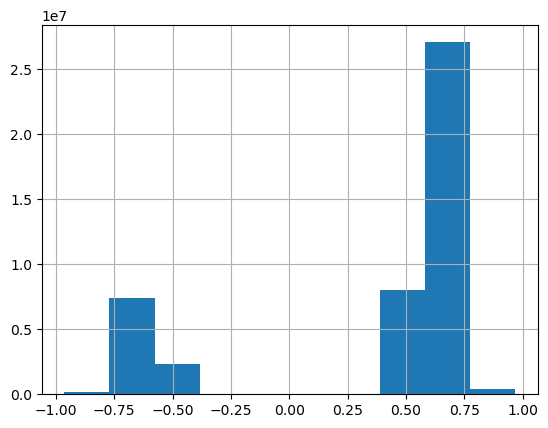

In [63]:
corr_check.sample(frac=0.1)["corr"].hist()

In [ ]:
corr_check.sample(frac=0.1)["corr"].abc()

In [ ]:
5

In [49]:
[i for i in METHYL_INDEX.glob("*ENSG00000280047*")]

[PosixPath('../preprocessing/methyl_index/methyl-ENSG00000280047-minus-.tsv.gz'),
 PosixPath('../preprocessing/methyl_index/methyl-ENSG00000280047-plus-.tsv.gz')]

In [5]:
METHYL_INDEX

PosixPath('../preprocessing/methyl_index')

In [26]:
len([i for i in METHYL_INDEX.glob("*/*-minus*")])

1486

In [27]:
len([i for i in METHYL_INDEX.glob("*/*-plus*")])

1283

In [28]:
len([i.stem.split("-")[1] for i in METHYL_INDEX.glob("*/*")])

2769

In [30]:
unique_lnc = set([i.stem.split("-")[1] for i in METHYL_INDEX.glob("*/*")])

In [31]:
len(unique_lnc)

1705

In [39]:
for lnc in unique_lnc:
    assert len([i for i in METHYL_INDEX.glob(f"*/*{lnc}*")]) < 3
# На одну lnc приходится по 2 файла +-

In [41]:
# Перенос файлов из подпапок в корень
target_dir = METHYL_INDEX
for source_dir in METHYL_INDEX.iterdir():
    if source_dir.is_dir():
        for file_path in source_dir.iterdir():
            if file_path.is_file():  # Проверяем, что это файл, а не директория
                target_path = target_dir / file_path.name
                file_path.rename(target_path)       

In [42]:
# Удаление пустых подпапок
for source_dir in METHYL_INDEX.iterdir():
    if source_dir.is_dir():
        source_dir.rmdir()

In [7]:
len([to_df for to_df in METHYL_INDEX.glob("*")])

2769

In [7]:
ENSG00000280047 = pd.concat([pd.read_csv(to_df, sep="\t", header=None).loc[1:] for to_df in METHYL_INDEX.glob("*ENSG00000280047*minus*")]).reset_index(drop=True)
ENSG00000280047

,0,1,2,3,4,5,6
0,chr13,99062576,99062577,peak_13294105,-0.855,ENSG00000280047,minus
1,chr13,99062606,99062607,peak_13294107,-0.89,ENSG00000280047,minus
2,chr13,99062612,99062613,peak_13294109,-0.856,ENSG00000280047,minus
3,chr2,32758365,32758366,peak_25313521,-0.869,ENSG00000280047,minus


In [9]:
ENSG00000280047 = pd.concat([pd.read_csv(to_df, sep="\t") for to_df in METHYL_INDEX.glob("*ENSG00000280047*minus*")]).reset_index(drop=True)
ENSG00000280047

,chrom,start,end,name,corr,lnc_ens,corr_sign
0,chr13,99062576,99062577,peak_13294105,-0.855,ENSG00000280047,minus
1,chr13,99062606,99062607,peak_13294107,-0.890,ENSG00000280047,minus
2,chr13,99062612,99062613,peak_13294109,-0.856,ENSG00000280047,minus
3,chr2,32758365,32758366,peak_25313521,-0.869,ENSG00000280047,minus


In [21]:
[to_df.name.split(".")[0] for to_df in METHYL_INDEX.glob("*ENSG00000280047*minus*")]

['methyl-ENSG00000280047-minus-']

In [6]:
dtype = {
    "chrom": str,
    "start": np.uint32,
    "end": np.uint32
}

In [36]:
len([to_df.name.split(".")[0] for to_df in METHYL_INDEX.glob("*minus*")])

1486

In [19]:
len([to_df.name.split(".")[0] for to_df in METHYL_INDEX.glob("*plus*")])

1283

In [ ]:
#Не хватает оперативной памяти
dtype = {
    "chrom": str,
    "start": np.uint32,
    "end": np.uint32
}
all_peaks = {}
for sign in "minus","plus":
    all_peaks[sign] = pd.concat([pd.read_csv(to_df, sep="\t", dtype=dtype, header=None).loc[1:] for to_df in METHYL_INDEX.glob(f"*{sign}*")]).reset_index(drop=True)\
    .drop_duplicates().dropna()
    
all_peaks_df = pd.concat([all_peaks[sign] for sign in ("minus","plus")]).drop_duplicates()
del all_peaks

/tmp/ipykernel_4679/652964208.py:9: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  all_peaks[sign] = pd.concat([pd.read_csv(to_df, sep="\t", dtype=dtype, header=None).loc[1:] for to_df in METHYL_INDEX.glob(f"*{sign}*")]).reset_index(drop=True)\
/tmp/ipykernel_4679/652964208.py:9: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  all_peaks[sign] = pd.concat([pd.read_csv(to_df, sep="\t", dtype=dtype, header=None).loc[1:] for to_df in METHYL_INDEX.glob(f"*{sign}*")]).reset_index(drop=True)\
/tmp/ipykernel_4679/652964208.py:9: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  all_peaks[sign] = pd.concat([pd.read_csv(to_df, sep="\t", dtype=dtype, header=None).loc[1:] for to_df in METHYL_INDEX.glob(f"*{sign}*")]).reset_index(drop=True)\
/tmp/ipykernel_4679/652964208.py:9: DtypeWarning: Columns (1,2,4) have mixed types. Spec

In [22]:
len(all_peaks["minus"])

1486

In [24]:
for sign in "plus":
    all_peaks[sign] = pd.concat([pd.read_csv(to_df, sep="\t", dtype=dtype, header=None).loc[1:] for to_df in METHYL_INDEX.glob(f"*{sign}*")]).reset_index(drop=True)\
    .drop_duplicates().dropna()

/tmp/ipykernel_14970/1971028378.py:2: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  all_peaks[sign] = pd.concat([pd.read_csv(to_df, sep="\t", dtype=dtype, header=None).loc[1:] for to_df in METHYL_INDEX.glob(f"*{sign}*")]).reset_index(drop=True)\
/tmp/ipykernel_14970/1971028378.py:2: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  all_peaks[sign] = pd.concat([pd.read_csv(to_df, sep="\t", dtype=dtype, header=None).loc[1:] for to_df in METHYL_INDEX.glob(f"*{sign}*")]).reset_index(drop=True)\
/tmp/ipykernel_14970/1971028378.py:2: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  all_peaks[sign] = pd.concat([pd.read_csv(to_df, sep="\t", dtype=dtype, header=None).loc[1:] for to_df in METHYL_INDEX.glob(f"*{sign}*")]).reset_index(drop=True)\
/tmp/ipykernel_14970/1971028378.py:2: DtypeWarning: Columns (1,2,4) have mixed typ

In [23]:
len(all_peaks["plus"])

619

In [26]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm

dtype = {
    "chrom": str,
    "start": np.uint32,
    "end": np.uint32
}

def process_file(file_path):
    df = pd.read_csv(file_path, sep="\t", dtype=dtype, header=None).iloc[1:]
    return df.drop_duplicates().dropna()

all_peaks = {"plus": [], "minus": []}

for sign in ("plus", "minus"):
    print(sign)
    for to_df in tqdm(METHYL_INDEX.glob(f"*{sign}*")):
        df = process_file(to_df)
        all_peaks[sign].append(df)
        del df

plus


0it [00:00, ?it/s]/tmp/ipykernel_8556/1272058404.py:13: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep="\t", dtype=dtype, header=None).iloc[1:]
6it [00:19,  3.03s/it]/tmp/ipykernel_8556/1272058404.py:13: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep="\t", dtype=dtype, header=None).iloc[1:]
8it [00:21,  2.24s/it]/tmp/ipykernel_8556/1272058404.py:13: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep="\t", dtype=dtype, header=None).iloc[1:]
9it [00:31,  3.94s/it]/tmp/ipykernel_8556/1272058404.py:13: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep="\t", dtype=dtype, header=None).iloc[1:]
13it [00:36,  2.42s/it]/tmp/ipykernel_8556/12720

minus


24it [00:00, 103.46it/s]/tmp/ipykernel_8556/1272058404.py:13: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep="\t", dtype=dtype, header=None).iloc[1:]
49it [00:01, 38.66it/s] /tmp/ipykernel_8556/1272058404.py:13: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep="\t", dtype=dtype, header=None).iloc[1:]
58it [00:11,  2.83it/s]/tmp/ipykernel_8556/1272058404.py:13: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep="\t", dtype=dtype, header=None).iloc[1:]
78it [00:14,  4.57it/s]/tmp/ipykernel_8556/1272058404.py:13: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep="\t", dtype=dtype, header=None).iloc[1:]
92it [00:23,  2.54it/s]/tmp/ipykernel_

In [27]:
len(all_peaks)

2

In [29]:
len(all_peaks["minus"])

1486

In [30]:
len(all_peaks["plus"])

1283

In [32]:
all_peaks_df_minus = pd.concat(all_peaks["minus"]).drop_duplicates().reset_index(drop=True)

In [33]:
del all_peaks["minus"]

In [34]:
all_peaks_df_plus = pd.concat(all_peaks["plus"]).drop_duplicates().reset_index(drop=True)

IOStream.flush timed out


MemoryError: Unable to allocate 2.64 GiB for an array with shape (354091718,) and data type int64

In [ ]:
del all_peaks["plus"]

In [ ]:
all_peaks_df_plus = pd.concat(all_peaks["plus"]).drop_duplicates().reset_index(drop=True)
all_peaks_df_minus = pd.concat(all_peaks["minus"]).drop_duplicates().reset_index(drop=True)

all_peaks_df = pd.concat([all_peaks_df_minus, all_peaks_df_plus]).drop_duplicates().reset_index(drop=True)
import gc
gc.collect()

print(all_peaks_df.head())

minus


/tmp/ipykernel_19918/213878017.py:12: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep="\t", dtype=dtype, header=None).iloc[1:]
/tmp/ipykernel_19918/213878017.py:12: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep="\t", dtype=dtype, header=None).iloc[1:]
/tmp/ipykernel_19918/213878017.py:12: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep="\t", dtype=dtype, header=None).iloc[1:]
/tmp/ipykernel_19918/213878017.py:12: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep="\t", dtype=dtype, header=None).iloc[1:]
/tmp/ipykernel_19918/213878017.py:12: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memo

plus


/tmp/ipykernel_19918/213878017.py:12: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep="\t", dtype=dtype, header=None).iloc[1:]
/tmp/ipykernel_19918/213878017.py:12: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep="\t", dtype=dtype, header=None).iloc[1:]
/tmp/ipykernel_19918/213878017.py:12: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep="\t", dtype=dtype, header=None).iloc[1:]
/tmp/ipykernel_19918/213878017.py:12: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep="\t", dtype=dtype, header=None).iloc[1:]
/tmp/ipykernel_19918/213878017.py:12: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memo

In [9]:
all_peaks

NameError: name 'all_peaks' is not defined

In [7]:
all_peaks_df_plus

NameError: name 'all_peaks_df_plus' is not defined

In [12]:
stream = open("file.bed", 'w')
df = ENSG00000280047
for i in range(len(df)):
    stream.write(f"{df.loc[i, 'chrom']}\t{df.loc[i, 'start']}\t{df.loc[i, 'end']}\n")
stream.close()

In [26]:
PREPROCESSING_DATA = Path("/data/magletdinov/git_projects/fantom.ips-himorna.peaks/preprocessing")
#METHYL_BED = PREPROCESSING / "methyl_bed"
METHYL_BED = PREPROCESSING_DATA / "methyl_bed"

In [21]:
def tsv_to_bed(to_tsv):
    to_save = METHYL_BED / f"{to_tsv.name.split('.')[0]}.bed"
    if to_save.exists():
        print(f"Skipped: {to_save}")
        return None
    to_save.parent.mkdir(exist_ok=True, parents=True)
    df = pd.read_csv(to_tsv, sep="\t")
    stream = open(to_save, 'w')
    for i in range(len(df)):
        stream.write(f"{df.loc[i, 'chrom']}\t{df.loc[i, 'start']}\t{df.loc[i, 'end']}\n")
    
    stream.close()
    cmd = f"gzip {to_save}" 
    subprocess.run(cmd, shell=True, check=True)

In [15]:
tsv_to_bed([to_df for to_df in METHYL_INDEX.glob("*ENSG00000280047*minus*")][0])

In [27]:
len([to_df for to_df in METHYL_BED.glob("*")])

0

In [30]:
with Parallel(n_jobs=-1) as pool:
    chunks = pool(
        delayed(tsv_to_bed)(to_tsv)
        for to_tsv in METHYL_INDEX.glob("*")
    )

/home/magletdinov/mambaforge/envs/work/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
